In [46]:
import cv2 as cv
import numpy as np
#from google.colab import drive
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



In [ ]:
import hashlib
import pickle

def model_hash(obj):
    return hashlib.md5(pickle.dumps(obj)).hexdigest()


In [48]:
#drive.mount('/content/drive',force_remount=True)
base_dir = 'Bone_Fracture_Binary_Classification'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

class_folders = ['fractured', 'not fractured']



In [49]:
def generate_bone_mask(img):

    blurred = cv.GaussianBlur(img, (5, 5), 0)
    thresh = cv.adaptiveThreshold(
        blurred, 255,
        cv.ADAPTIVE_THRESH_MEAN_C,
        cv.THRESH_BINARY,
        11, 2
    )
    thresh = cv.bitwise_not(thresh)
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=1)

    return cleaned



In [50]:
def extract_all_sift_descriptors(folder_path):
    sift = cv.SIFT_create()
    all_descriptors = []

    for class_name in class_folders:
        class_path = os.path.join(folder_path, class_name)
        img_files = os.listdir(class_path)

        for img_file in tqdm(img_files, desc=f"Extracting SIFT from {class_name}"):
            img_path = os.path.join(class_path, img_file)
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            if img is None:
                continue

            img = cv.resize(img, (256, 256))   #good trade-off between detail and speed
            mask = generate_bone_mask(img)
            keypoints, descriptors = sift.detectAndCompute(img, None)
            if descriptors is not None:
                all_descriptors.extend(descriptors)
    return np.array(all_descriptors)




In [51]:
all_descriptors = extract_all_sift_descriptors(train_dir)
K = 100
kmeans = MiniBatchKMeans(n_clusters=K, batch_size=1000)
kmeans.fit(all_descriptors)

print("Visual vocabulary created with", K, "words.")



Extracting SIFT from not fractured: 100%|██████████| 4640/4640 [02:07<00:00, 36.37it/s]
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Visual vocabulary created with 100 words.


In [52]:
def create_bow_histograms(folder_path, kmeans_model):
    sift = cv.SIFT_create()
    X = []
    y = []

    for label_idx, class_name in enumerate(class_folders):
        class_path = os.path.join(folder_path, class_name)
        img_files = os.listdir(class_path)

        for img_file in tqdm(img_files, desc=f"Creating BoW for {class_name}"):
            img_path = os.path.join(class_path, img_file)
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            if img is None:
                continue

            img = cv.resize(img, (256, 256))
            keypoints, descriptors = sift.detectAndCompute(img, None)

            if descriptors is not None:
                predictions = kmeans_model.predict(descriptors)
                hist, _ = np.histogram(predictions, bins=np.arange(K + 1))
                X.append(hist)
                y.append(label_idx)

    return np.array(X), np.array(y)



In [53]:
X_train, y_train = create_bow_histograms(train_dir, kmeans)
X_val, y_val = create_bow_histograms(val_dir, kmeans)
X_test, y_test = create_bow_histograms(test_dir, kmeans)



Creating BoW for not fractured: 100%|██████████| 268/268 [00:09<00:00, 27.40it/s]


In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



In [55]:
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

y_pred_test = svm.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))



Validation Accuracy: 0.9227985524728589
Test Accuracy: 0.950592885375494


In [56]:
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix validation :\n", cm)



Confusion Matrix validation :
 [[281  56]
 [  8 484]]


In [57]:
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix test:\n", cm)



Confusion Matrix test:
 [[221  17]
 [  8 260]]


In [70]:
#imgTest=cv.imread('test.jpg',cv.IMREAD_GRAYSCALE)
imgTest=cv.imread('notFracturedTEST.jpg',cv.IMREAD_GRAYSCALE)
if imgTest is None:
    print("Error: Could not load image.")

img_resized = cv.resize(imgTest, (256, 256))



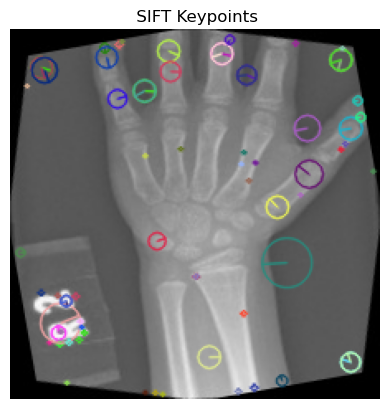

In [71]:
sift = cv.SIFT_create()
keypoints_cv, descriptors_cv = sift.detectAndCompute(imgTest, None)
output_cv = cv.drawKeypoints(
    imgTest, keypoints_cv, None,
    flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plt.imshow(output_cv[..., ::-1])  # BGR to RGB
plt.title(" SIFT Keypoints")
plt.axis('off')
plt.show()



In [72]:
if descriptors_cv is not None:
    predictions = kmeans.predict(descriptors_cv)
    K = 100 # From the notebook
    hist, _ = np.histogram(predictions, bins=np.arange(K + 1))
    # Reshape for scaling
    hist_reshaped = hist.reshape(1, -1)
else:
    print("No SIFT descriptors found for the image.")
    hist_reshaped = None # Handle cases with no descriptors


if hist_reshaped is not None:
    scaled_hist = scaler.transform(hist_reshaped)


if scaled_hist is not None:
    prediction_label = svm.predict(scaled_hist)[0]
    class_folders = ['fractured', 'not fractured']
    predicted_class = class_folders[prediction_label]
    print(f"The image is predicted as: {predicted_class}")

    

The image is predicted as: not fractured


In [69]:
import pickle

with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)


print("Notebook Hashes:")
print("KMeans:", model_hash(kmeans))
print("Scaler:", model_hash(scaler))
print("SVM:", model_hash(svm))



Notebook Hashes:
KMeans: 804d917f2f72f49c1c37970033e9e856
Scaler: ff710f45df350db508ba71a9fcf5a987
SVM: a172196a1cab418e78a9482f764dced4
